In [1]:
%matplotlib inline
from __future__ import print_function
from torch.autograd import Variable
from random import randint
import torch
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
images1 = np.load("images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width)
labels1 = np.load("labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor)

In [3]:
for k in range(len(labels)): # push non apple classes to 0
    if labels[k] != 0:
        labels[k] = 0
    else:
        labels[k] = 1

        
images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)
# the above normalizes the data based on z score


# split the data into train, dev, test
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

In [4]:
class lr():

    def __init__(self, learning_rate, iterations):
        self.num_input_features = None
        self.lr = learning_rate #learning rate
        self.iterations = iterations #num iterations
        self.count = 0
        self.num_iterations_vals = []
        self.accuracy_vals_train = []
        self.accuracy_vals_dev = []
        self.total_iterations = 0
        
    def accuracy(self, y, y_hat):
        return (y == y_hat).astype(np.float).mean()
        
    def fit(self, X, Y, X_dev, Y_dev):
        temp = torch.DoubleTensor(X.shape[1]).zero_()
        self.w = Variable(temp, requires_grad=True)
        for j in range(self.iterations): #for iterations amount of times
            for i in range(X.shape[0]):
                if (self.count == 100): # every 100 iterations, do this
                    self.total_iterations += 100
                    self.count = 0
                    y_hat1 = np.zeros(1000)
                    y_actual = np.zeros(1000)
                    y_hat_dev = np.zeros(1000)
                    y_actual_dev = np.zeros(1000)
                    for z in range(1000): # sample 1000 points
                        rand_int = randint(0, 39999) # random index for training
                        rand_int_dev = randint(0, 4999) # random index for dev
                        intermediate1 = torch.FloatTensor([self.w.data.dot(X[rand_int])])
                        intermediate2 = torch.FloatTensor([self.w.data.dot(X_dev[rand_int_dev])])
                        sig1 = torch.sigmoid(intermediate1) # pass through sigmoid to get 0 <= value <= 1
                        sig2 = torch.sigmoid(intermediate2)
                        y_actual[z] = Y[rand_int]
                        y_actual_dev[z] = Y_dev[rand_int_dev]
                        if (sig1 >= .5).numpy(): # if output of sigmoid is geater than .5, then apple
                            y_hat1[z] = 1
                        else:
                            y_hat1[z] = 0
                        if (sig2 >= .5).numpy():
                            y_hat_dev[z] = 1
                        else:
                            y_hat_dev[z] = 0
                    self.num_iterations_vals.append(self.total_iterations)
                    self.accuracy_vals_train.append(self.accuracy(y_actual, y_hat1))
                    self.accuracy_vals_dev.append(self.accuracy(y_actual_dev, y_hat_dev))

                x = Variable(X[i]) # specific example
                y = Variable(torch.DoubleTensor([Y[i]]))
                ttt = torch.clamp(self.w.dot(x), -50, 50) # clamp to prevent nan values
                y_hat = torch.sigmoid(ttt)
                loss = -1 * y * torch.log(y_hat) - (1 - y) * torch.log(1 - y_hat) # loss 
                loss.backward() # automatic differentiation
                self.w.data = self.w.data - self.lr * self.w.grad.data # update
                self.w.grad.data.zero_() # zero the gradient
                self.count += 1
        return self

In [5]:
lr = lr(.01, 1)
train_data = train_data.type(torch.DoubleTensor)
dev_data = dev_data.type(torch.DoubleTensor)
lr.fit(train_data, train_labels, dev_data, dev_labels)

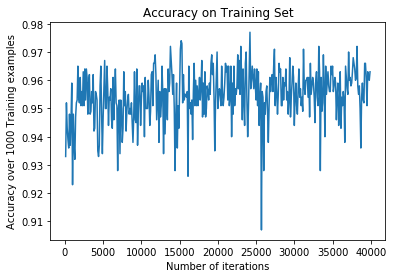

In [6]:
plt.plot(lr.num_iterations_vals, lr.accuracy_vals_train)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

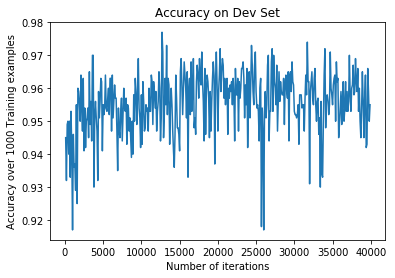

In [7]:
plt.plot(lr.num_iterations_vals, lr.accuracy_vals_dev)
plt.title("Accuracy on Dev Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

No, there does not appear to be any overfitting. We can see that the accuracy over each 1000 examples of train/dev data stays relatively constant at around 96%, and does not decrease at all.